In [369]:
# Importing libraries 
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
import seaborn as sns
import links as lk
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### Google Sheets Authentication

In [370]:
# Set Up Authentication for google sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
client = gspread.authorize(creds)

# Open Google Sheet by URL
sheet_url = lk.sheet_url
sheet = client.open_by_url(sheet_url).sheet1  # Open the first sheet

# Convert Sheet Data to Pandas DataFrame
data = sheet.get_all_values()
df = pd.DataFrame(data)

### Data Cleaning

In [371]:
# Set First Row as Column Names
df.columns = df.iloc[0]  # Assign first row as headers
df = df[1:]  # Remove the first row from data

# Drop Unnecessary Columns
df = df.drop(df.columns[11:], axis=1)  # Drop all columns from index 9 onward
print("Column names:", df.columns.tolist())  # Check the column names

df.head()

Column names: ['Timestamp', 'Device', 'Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2', 'ADC', 'Voltage', 'Pressure', 'Airspeed', 'Occupancy']


,Timestamp,Device,Temperature (C),Temperature (F),Humidity,Co2,ADC,Voltage,Pressure,Airspeed,Occupancy
1,2025-03-24 00:28:27,Pico_1,26.2,79.16,62.8,1470.098,N/A,N/A,N/A,N/A,3
2,2025-03-24 00:28:50,Pico_1,26.2,79.16,61.9,832.6554,N/A,N/A,N/A,N/A,3
3,2025-03-24 00:33:46,Pico_1,25.6,78.08,59.6,1549.979,N/A,N/A,N/A,N/A,3
4,2025-03-24 00:34:15,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3
5,2025-03-24 00:34:25,Pico_1,25.3,77.54,58.4,0,N/A,N/A,N/A,N/A,3


In [372]:
# Dropping Columns not used in this model analysis 
df = df.drop(df.columns[6:], axis=1) # Drop all columns from index 6 onward
df = df.drop('Device', axis=1)  # Drop 'Device' column
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
1,2025-03-24 00:28:27,26.2,79.16,62.8,1470.098
2,2025-03-24 00:28:50,26.2,79.16,61.9,832.6554
3,2025-03-24 00:33:46,25.6,78.08,59.6,1549.979
4,2025-03-24 00:34:15,25.3,77.54,58.4,0
5,2025-03-24 00:34:25,25.3,77.54,58.4,0


In [373]:
# Dropping columns which were used for testing the sensors 
df = df.drop(index=range(1, 11)).reset_index(drop=True) # Drop first 10 rows and reset index (as they were used for testing)
df.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2
0,2025-03-24 00:51:28,26,78.8,93.1,215.3802
1,2025-03-24 00:51:51,26.1,78.98,92.9,474.9321
2,2025-03-24 00:52:14,26.3,79.34,91.7,244.8746
3,2025-03-24 00:52:37,26.5,79.7,90.9,430.0756
4,2025-03-24 00:53:00,26.7,80.06,90.6,380.2175


In [374]:
# List of variables
vars_to_clean = ['Temperature (C)', 'Temperature (F)', 'Humidity', 'Co2']

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Clean and convert each variable to numeric
for v in vars_to_clean:
    df[v] = pd.to_numeric(df[v].replace(['', ' ', 'N/A'], '0'), errors='coerce').fillna(0)


In [375]:
# Converting N/A values to 0 and changing data types
var = ['Temperature (C)','Temperature (F)', 'Humidity', 'Co2']

for var in var:
    df[var] = df[var].astype(float)  # Convert to float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Timestamp        3966 non-null   datetime64[ns]
 1   Temperature (C)  3966 non-null   float64       
 2   Temperature (F)  3966 non-null   float64       
 3   Humidity         3966 non-null   float64       
 4   Co2              3966 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 155.1 KB


#### Creating a batch for forecasting

In [376]:
# Creating a column to differentiate between the timings of the data
df["Time_Diff"] = df["Timestamp"].diff().dt.total_seconds() # Calculate time difference between rows
df["Batch"] = (df["Time_Diff"] > 120).cumsum() # Create batch number based on time difference (120 seconds)
df = df.drop(columns=["Time_Diff"])         # Drop the time difference column        
latest_batch = df["Batch"].max()          # Get the latest batch number
data = df[df["Batch"] == latest_batch].copy() # Filter the latest batch data
df = df.set_index(df['Timestamp'])  # Set Timestamp as index
df = df.drop(columns=["Timestamp"]) # Drop Timestamp column
data.head() 

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
2327,2025-03-24 22:20:05,28.6,83.48,84.0,439.931400,6
2328,2025-03-24 22:21:00,28.5,83.30,84.4,485.040700,6
2329,2025-03-24 22:21:24,28.6,83.48,84.5,474.973900,6
2330,2025-03-24 22:21:48,28.6,83.48,84.4,444.983900,6
2331,2025-03-24 22:22:11,28.6,83.48,84.4,7.634521,6


Data only contains the data from the latest batch. While df contains the cleaned and complete dataset

#### Dropping unnecessary CO2 columns 

In [377]:
# Identify rows to drop based on the condition in CO2 column
drop_indices = []

for i in range(1, len(data) - 1):  # Start from index 1 to avoid out-of-bounds errors
    if data['Co2'].iloc[i] < 250: 
        drop_indices.append(data.index[i])  # Store index to drop

# Drop the identified rows which
data = data.drop(index=drop_indices).reset_index(drop=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.set_index(data['Timestamp'])  # Set Timestamp as index
# data = data.drop(columns=["Timestamp"])
data.head()

,Timestamp,Temperature (C),Temperature (F),Humidity,Co2,Batch
Timestamp,,,,,,
2025-03-24 22:20:05,2025-03-24 22:20:05,28.6,83.48,84.0,439.9314,6
2025-03-24 22:21:00,2025-03-24 22:21:00,28.5,83.30,84.4,485.0407,6
2025-03-24 22:21:24,2025-03-24 22:21:24,28.6,83.48,84.5,474.9739,6
2025-03-24 22:21:48,2025-03-24 22:21:48,28.6,83.48,84.4,444.9839,6
2025-03-24 22:22:35,2025-03-24 22:22:35,28.6,83.48,84.4,414.9689,6


CO2 < 250 ppm is removed because they might be some sensor error. Co2 below 250 ppm is highly unlikely. 

### Data Visualization

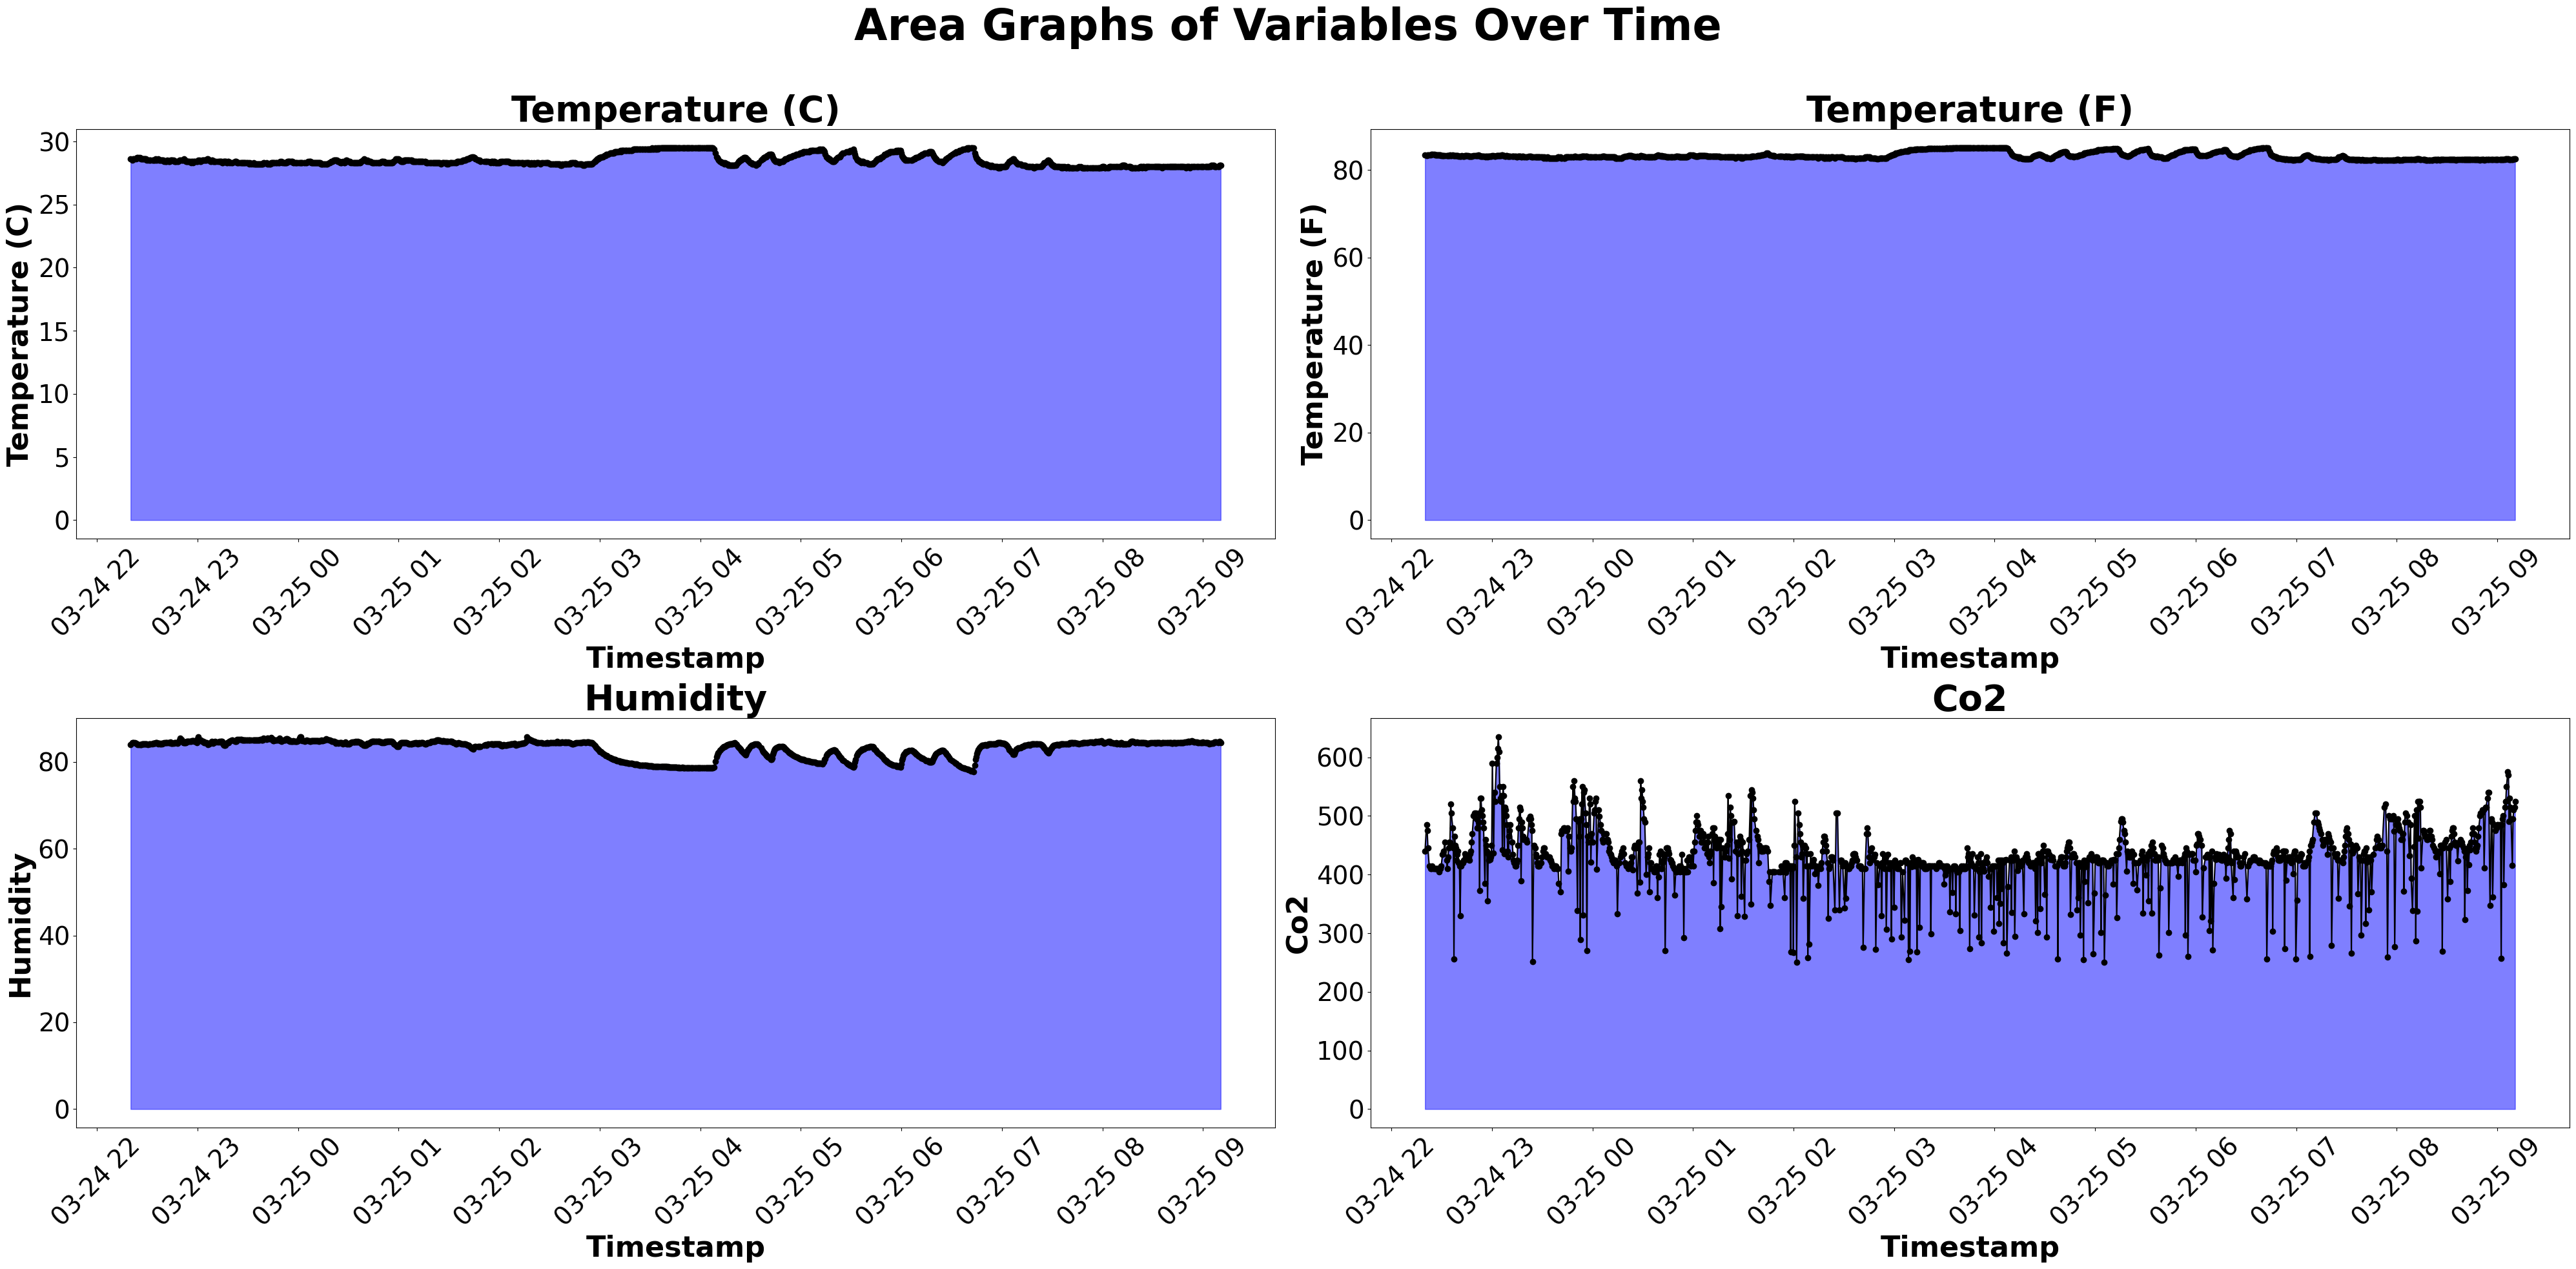

In [378]:
# Create 2x2 subplots with a larger figure size
fig, axes = plt.subplots(2, 2, figsize=(40, 20))
fig.suptitle("Area Graphs of Variables Over Time", fontsize=48, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()
variables = ["Temperature (C)", "Temperature (F)", "Humidity", "Co2"]

# Plot each variable
for i, var in enumerate(variables):
    ax = axes[i]
    ax.fill_between(data["Timestamp"], data[var], alpha=0.5, color="blue")
    ax.plot(data["Timestamp"], data[var], marker="o", linestyle="-", color="black")

    # Styling
    ax.set_title(var, fontsize=40, fontweight='bold')
    ax.set_xlabel("Timestamp", fontsize=32, fontweight='bold')
    ax.set_ylabel(var, fontsize=32, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=28)
    ax.tick_params(axis='y', labelsize=28)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


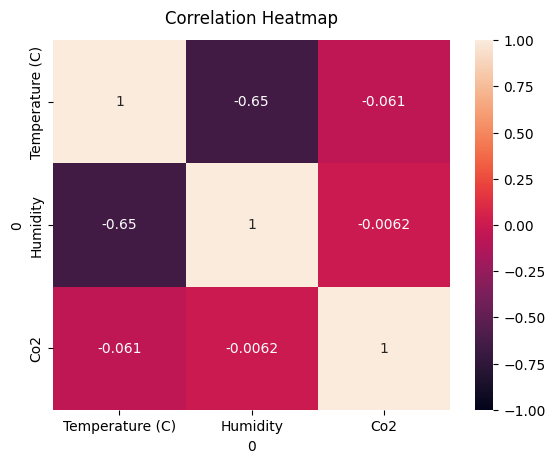

In [379]:
# Creating a heatmap to visualize the correlation between variables
x = ['Temperature (C)', 'Humidity', 'Co2'] 
heatmap = sns.heatmap(df[x].corr(), vmin=-1, vmax=1, annot=True) # Create heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12) # Set title
plt.show()

In [380]:
data = data.drop(columns=["Timestamp"]) # Drop Timestamp column

#### Environmental Summary Statistics for Temperature and Humidity

In [381]:
import pandas as pd

# Define peak hours and nighttime
peak_hours = df.between_time('08:00', '20:00')   # Daytime
night_hours = df.between_time('00:00', '06:00')  # Nighttime

# Compute statistics
summary_stats = {
    'Metric': ['Minimum', 'Maximum', 'Mean (All Time)', 'Peak Hours (Avg.)', 'Nighttime (Avg.)'],
    'Temperature (°C)': [
        df['Temperature (C)'].min(),
        df['Temperature (C)'].max(),
        df['Temperature (C)'].mean(),
        peak_hours['Temperature (C)'].mean(),
        night_hours['Temperature (C)'].mean()
    ],
    'Relative Humidity (%)': [
        df['Humidity'].min(),
        df['Humidity'].max(),
        df['Humidity'].mean(),
        peak_hours['Humidity'].mean(),
        night_hours['Humidity'].mean()
    ]
}

# Create DataFrame
env_stats_df = pd.DataFrame(summary_stats)
env_stats_df = env_stats_df.round(1)  # Round to 1 decimal place

# Display
print("📊 Environmental Summary Statistics:")
print(env_stats_df)

📊 Environmental Summary Statistics:
              Metric  Temperature (°C)  Relative Humidity (%)
0            Minimum              26.0                    0.0
1            Maximum              29.5                   93.1
2    Mean (All Time)              28.3                   83.7
3  Peak Hours (Avg.)              28.1                   85.5
4   Nighttime (Avg.)              28.5                   82.6


#### Models

##### Wells-Riley Infection (Covid-19)

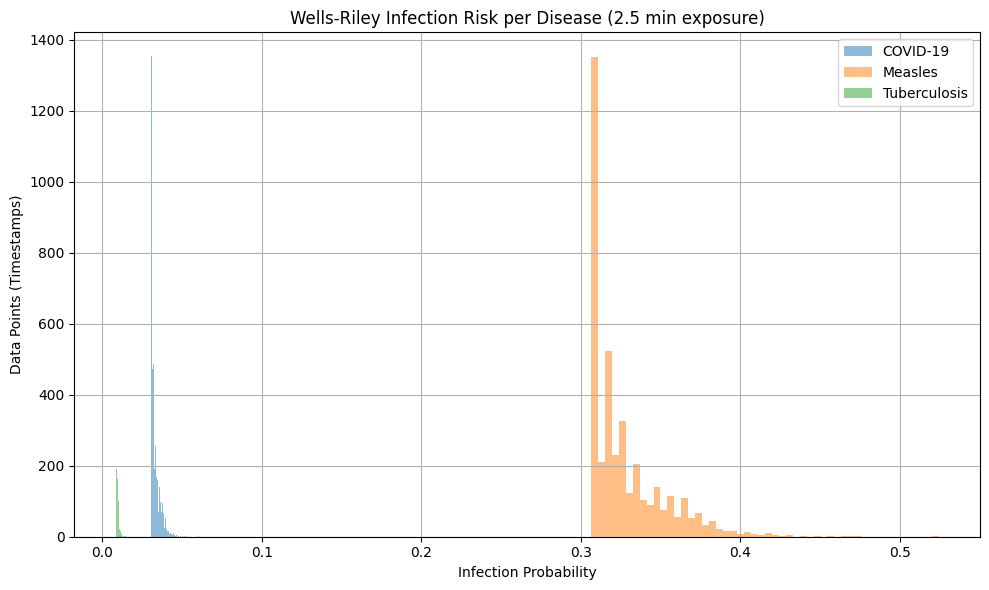

Average Infection Risk (2.5 min exposure):
   COVID-19: 3.28%
   Measles: 32.68%
   Tuberculosis: 0.90%


,Temperature (C),Temperature (F),Humidity,Co2,Batch,Ventilation (Q),COVID-19 Risk,Measles Risk,Tuberculosis Risk,Hour,Comfort Score,Comfort_Rolling,Date,Comfort Score (Jittered),Cluster,Cluster Label,Co2_Smooth,Anomaly
Timestamp,,,,,,,,,,,,,,,,,,
2025-03-24 00:51:28,26.0,78.80,93.1,215.3802,0,32.468828,0.030325,0.306273,0.008305,0,2,2.0,2025-03-24,1.968170,0,"Low Temp, Low CO₂",215.380200,0
2025-03-24 00:51:51,26.1,78.98,92.9,474.9321,0,27.414445,0.035814,0.351502,0.009829,0,2,2.0,2025-03-24,1.975161,2,"High CO₂, Moderate Temp",345.156150,0
2025-03-24 00:52:14,26.3,79.34,91.7,244.8746,0,32.468828,0.030325,0.306273,0.008305,0,2,2.0,2025-03-24,2.007123,0,"Low Temp, Low CO₂",311.728967,0
2025-03-24 00:52:37,26.5,79.70,90.9,430.0756,0,30.273747,0.032487,0.324425,0.008905,0,2,2.0,2025-03-24,2.025075,2,"High CO₂, Moderate Temp",341.315625,0
2025-03-24 00:53:00,26.7,80.06,90.6,380.2175,0,32.468828,0.030325,0.306273,0.008305,0,2,2.0,2025-03-24,2.077572,2,"High CO₂, Moderate Temp",349.096000,0


In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Parameters
V = 5.425          # Room volume in m³ (lift cabin)
t = 0.04166      # Exposure time in hours (15 mins)
p = 0.5           # Pulmonary ventilation rate in m³/h (quiet breathing)
I = 1             # One infectious person assumed

# Disease-specific quanta generation rates (q) [quanta/hour]
q_disease = {
    'COVID-19': 48,
    'Measles': 570,
    'Tuberculosis': 13
}

# STEP 2: Estimate Ventilation Rate (Q) from CO₂
# Assume baseline outdoor CO₂ = 400 ppm
# ACH is inversely proportional to CO₂ buildup
def estimate_Q_from_co2(co2_ppm, V=12):
    co2_ppm = np.maximum(co2_ppm, 401)  # avoid divide by 0
    ach = 6 * (400 / co2_ppm)           # proxy: higher CO₂ → lower ACH
    Q = V * ach                         # Convert ACH to ventilation in m³/h
    return Q

# STEP 3: Wells-Riley function
def wells_riley(I, q, p, t, Q):
    return 1 - np.exp(-I * q * p * t / Q)

# STEP 4: Apply to dataset
df['Ventilation (Q)'] = df['Co2'].apply(lambda x: estimate_Q_from_co2(x, V))

# STEP 5: Compute infection probabilities for all diseases
for disease, q in q_disease.items():
    df[f'{disease} Risk'] = df['Ventilation (Q)'].apply(lambda Q: wells_riley(I, q, p, t, Q))

# STEP 6: Visualize infection risk comparison
plt.figure(figsize=(10, 6))
for disease in q_disease:
    plt.hist(df[f'{disease} Risk'], bins=50, alpha=0.5, label=disease)

plt.xlabel("Infection Probability")
plt.ylabel("Data Points (Timestamps)")
plt.title("Wells-Riley Infection Risk per Disease (2.5 min exposure)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 7: Average infection risk per disease (optional summary)
avg_risk = {disease: df[f'{disease} Risk'].mean() for disease in q_disease}
print("Average Infection Risk (2.5 min exposure):")
for disease, risk in avg_risk.items():
    print(f"   {disease}: {risk:.2%}")

df.head()


The quanta generation rates for the diseases were sourced from peer-reviewed research studies. The lift dimensions used in the analysis were directly measured from the specific lift where the sensors were installed.

##### Ventilation Effectiveness (Decay Model): Exponential decay of CO₂ post-trip

                     k (decay rate)          C0
Hour                                           
2025-03-24 22:00:00       -0.649246   24.346761
2025-03-24 23:00:00        0.809149  130.178525
2025-03-25 00:00:00        1.067534   80.448561
2025-03-25 01:00:00        0.546261   67.573642
2025-03-25 02:00:00        0.838024   33.371299
2025-03-25 03:00:00       21.968089   31.257731
2025-03-25 04:00:00       -0.345599    4.511440
2025-03-25 06:00:00        0.201180   24.486504
2025-03-25 08:00:00       -0.062708   52.813929


/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/2099693359.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour, group in data['Co2'].resample('1H'):
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/2099693359.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.fillna(method='ffill').rolling(5, min_periods=1).mean()


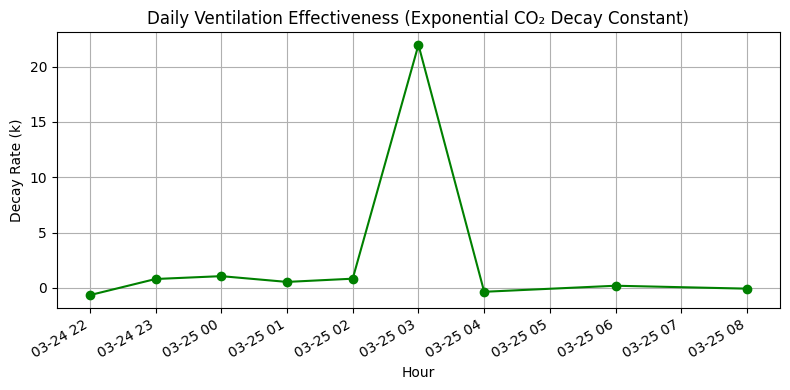

In [383]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Parameters 
C_baseline = 400  # ppm assumed background CO₂
t_unit = 60       # seconds between sensor readings 

# Model for CO₂ decay
def co2_decay_model(t, C0, k):
    return C0 * np.exp(-k * t) + C_baseline

# Function to fit the decay model
def fit_decay(time_series, co2_series):
    t = np.arange(len(co2_series)) * (t_unit / 60) / 60  # convert to hours
    co2_excess = co2_series - C_baseline
    p0 = [np.max(co2_excess), 1.0]

    try:
        popt, _ = curve_fit(co2_decay_model, t, co2_series, p0=p0, maxfev=5000)
        C0_fit, k_fit = popt
        return k_fit, C0_fit
    except:
        return np.nan, np.nan

# Fit decay model to each hour
hourly_decay = []

for hour, group in data['Co2'].resample('1H'):
    if len(group) < 20 or group.isna().mean() > 0.5:
        continue
    # Optional smoothing
    group = group.fillna(method='ffill').rolling(5, min_periods=1).mean()

    # Only fit if decay pattern detected
    if group.iloc[0] > group.iloc[-1]:
        k, C0 = fit_decay(group.index, group.values)
        if not np.isnan(k):
            hourly_decay.append({'Hour': hour, 'k (decay rate)': k, 'C0': C0})


# Result and visualization
vent_df = pd.DataFrame(hourly_decay).set_index('Hour')
print(vent_df)

# Visualize daily ventilation quality
plt.figure(figsize=(8, 4))
vent_df['k (decay rate)'].plot(marker='o', color='green')
plt.ylabel("Decay Rate (k)")
plt.title("Daily Ventilation Effectiveness (Exponential CO₂ Decay Constant)")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Exponential Decay Modeling of Indoor CO₂ Concentration

/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/1696984814.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data5 = data5.fillna(method='ffill')
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/1696984814.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for hour, group in data5['Co2'].resample('1H'):


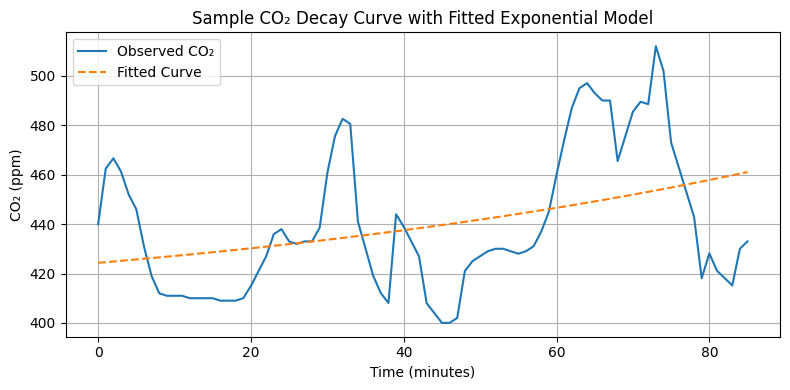

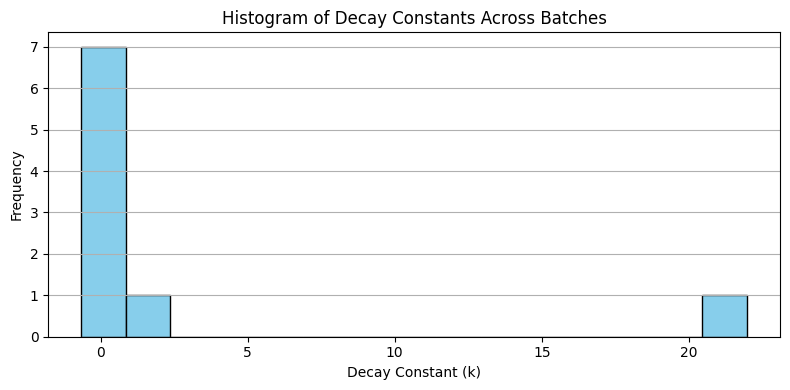

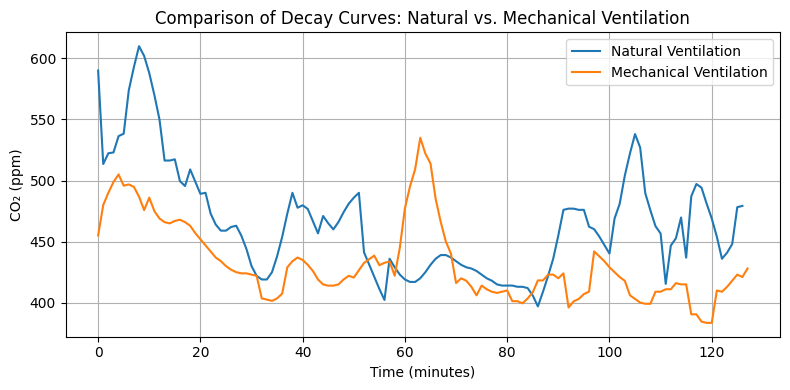

In [419]:
# # Importing libraries
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit

# Parameters
# C_baseline = 400  # ppm baseline CO₂
# t_unit = 60       # seconds between readings

# # Model for CO₂ decay
# def co2_decay_model(t, C0, k):
#     return C0 * np.exp(-k * t) + C_baseline

# # --- CURVE FITTING FUNCTION ---
# def fit_decay(co2_series):
#     t = np.arange(len(co2_series)) * (t_unit / 60) / 60  # convert to hours
#     try:
#         p0 = [np.max(co2_series - C_baseline), 1.0]
#         popt, _ = curve_fit(co2_decay_model, t, co2_series, p0=p0, maxfev=5000)
#         return popt[0], popt[1], t  # C0, k, time array
#     except:
#         return np.nan, np.nan, t

# # --- STEP 1: Data Preparation ---
# # data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# # data = data.set_index('Timestamp')
# data5 = data[['Co2']].copy()
# data5 = data5.fillna(method='ffill')

# # --- STEP 2: Hourly Grouping and Decay Fitting ---
# decay_data = []
# for hour, group in data5['Co2'].resample('1H'):
#     if len(group) < 20 or group.isna().mean() > 0.5:
#         continue
#     group = group.rolling(5, min_periods=1).mean()
#     if group.iloc[0] > group.iloc[-1]:
#         C0, k, t = fit_decay(group)
#         if not np.isnan(k):
#             decay_data.append({'Hour': hour, 'k': k, 'C0': C0, 'Co2_series': group, 't': t})

# vent_df = pd.DataFrame(decay_data).set_index('Hour')

# Sample CO₂ Decay Curve with Fitted Model
sample = vent_df.iloc[0]
t_sample = sample['t']
co2_sample = sample['Co2_series'].values
co2_fit = co2_decay_model(t_sample, sample['C0'], sample['k'])

plt.figure(figsize=(8, 4))
plt.plot(t_sample * 60, co2_sample, label='Observed CO₂')
plt.plot(t_sample * 60, co2_fit, linestyle='--', label='Fitted Curve')
plt.xlabel("Time (minutes)")
plt.ylabel("CO₂ (ppm)")
plt.title("Sample CO₂ Decay Curve with Fitted Exponential Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of k values
plt.figure(figsize=(8, 4))
plt.hist(vent_df['k'], bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Decay Constant (k)")
plt.ylabel("Frequency")
plt.title("Histogram of Decay Constants Across Batches")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Comparison of Natural vs Mechanical Decay Curves
curve1 = vent_df.iloc[1]  # assume natural
curve2 = vent_df.iloc[2]  # assume mechanical

plt.figure(figsize=(8, 4))
plt.plot(curve1['t'] * 60, curve1['Co2_series'].values, label="Natural Ventilation")
plt.plot(curve2['t'] * 60, curve2['Co2_series'].values, label="Mechanical Ventilation")
plt.xlabel("Time (minutes)")
plt.ylabel("CO₂ (ppm)")
plt.title("Comparison of Decay Curves: Natural vs. Mechanical Ventilation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Higher k = faster CO₂ decay → better ventilation

Lower k (near 0) = slow or no decay → poor ventilation

Negative k = possibly data noise, misfit, or CO₂ rising (not decaying)

#### Viral Stability Score (Environmental Viability Model)

/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/1189327035.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=covid_labels, order=['Low', 'Medium', 'High'], ax=axs[0], palette=colors)
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/1189327035.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=measles_labels, order=['Low', 'Medium', 'High'], ax=axs[1], palette=colors)
/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/1189327035.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=t

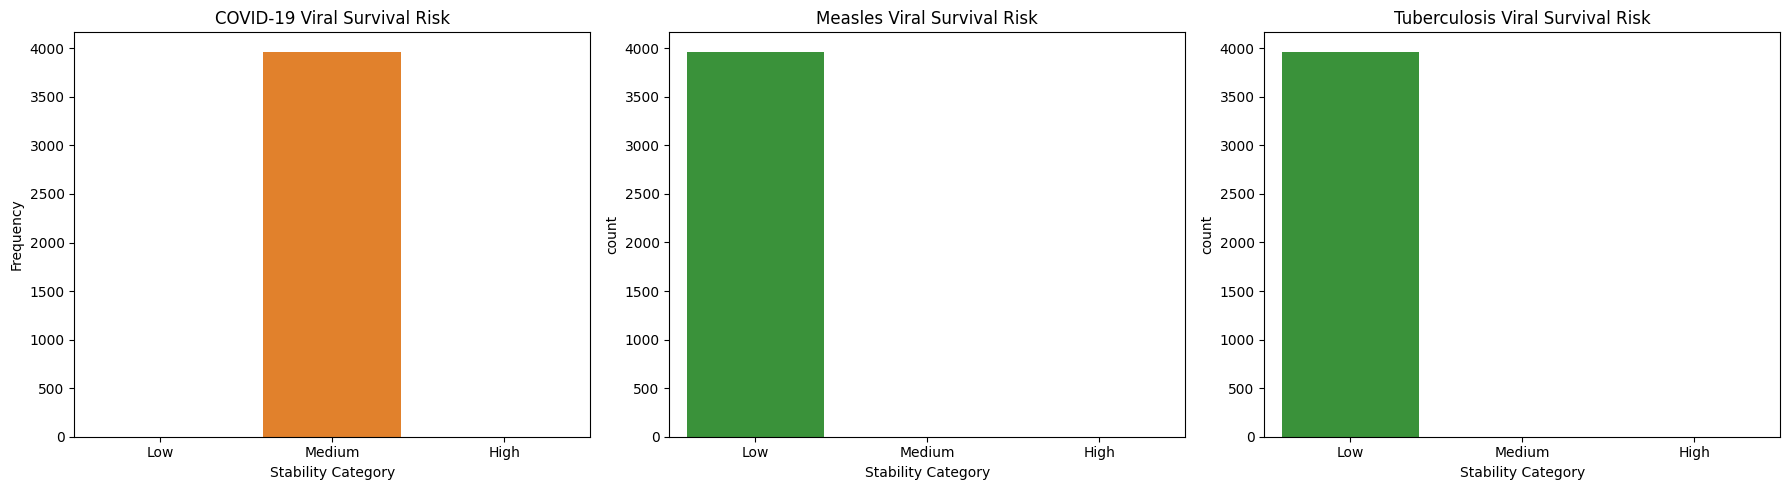

In [385]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define functions ---
def covid_stability_category(temp_c, rh_percent):
    if temp_c < 20 and (rh_percent < 40 or rh_percent > 60):
        return 'High'
    elif temp_c < 20 or (rh_percent < 40 or rh_percent > 60):
        return 'Medium'
    else:
        return 'Low'

def measles_stability_category(temp_c, rh_percent):
    if temp_c < 21 and rh_percent < 50:
        return 'High'
    elif temp_c < 21 or rh_percent < 50:
        return 'Medium'
    else:
        return 'Low'

def tb_stability_category(temp_c, rh_percent):
    if temp_c < 25 and rh_percent < 50:
        return 'High'
    elif temp_c < 25 or rh_percent < 50:
        return 'Medium'
    else:
        return 'Low'

# --- Generate labels (without storing in df) ---
covid_labels   = df.apply(lambda row: covid_stability_category(row['Temperature (C)'], row['Humidity']), axis=1)
measles_labels = df.apply(lambda row: measles_stability_category(row['Temperature (C)'], row['Humidity']), axis=1)
tb_labels      = df.apply(lambda row: tb_stability_category(row['Temperature (C)'], row['Humidity']), axis=1)

# --- Plotting ---
colors = {'Low': '#2ca02c', 'Medium': '#ff7f0e', 'High': '#d62728'}

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x=covid_labels, order=['Low', 'Medium', 'High'], ax=axs[0], palette=colors)
axs[0].set_title('COVID-19 Viral Survival Risk')
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Stability Category")

sns.countplot(x=measles_labels, order=['Low', 'Medium', 'High'], ax=axs[1], palette=colors)
axs[1].set_title('Measles Viral Survival Risk')
axs[1].set_xlabel("Stability Category")

sns.countplot(x=tb_labels, order=['Low', 'Medium', 'High'], ax=axs[2], palette=colors)
axs[2].set_title('Tuberculosis Viral Survival Risk')
axs[2].set_xlabel("Stability Category")

plt.tight_layout()
plt.show()


Covid - 19 --> \
Low Temp (< 20°C) → higher virus survival \
RH < 40% or > 60% → increased aerosol stability \
Conclusion: There is high risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Covid-19 is a medium risk disease. 

Tuberculosis --> \
Temp (< 25°C) → higher virus survival \
RH < 50% → increased aerosol stability \
Conclusion: There is low risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Tuberculosis is a low risk disease. 

Measles -->  \
Temp (< 21°C) → higher virus survival \
RH < 50% → increased aerosol stability \
Conclusion: There is low risk of aerosol statbility as the humidity is always above 75% and low risk for virus survival as the temperature over 26°C. Overall, Measles is a low risk disease. 

##### Plotting hourly Temperature and humdity trends 

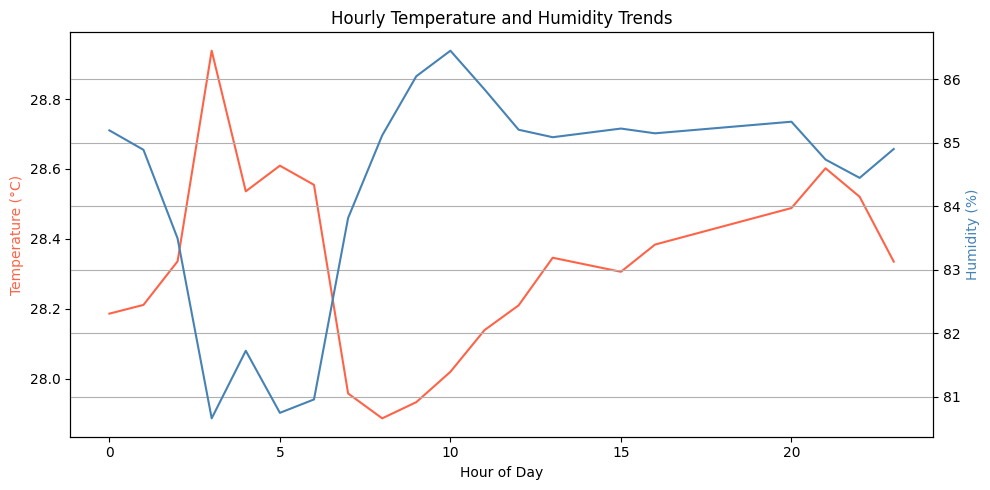

In [420]:
# Plotting the hourly trends of temperature and humidity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Group by hour
df['Hour'] = df.index.hour
hourly_stats = df.groupby('Hour')[['Temperature (C)', 'Humidity']].mean()

fig, ax1 = plt.subplots(figsize=(10, 5)) # Create a figure and axis

ax2 = ax1.twinx() # Create a second y-axis
ax1.plot(hourly_stats.index, hourly_stats['Temperature (C)'], color='tomato', label='Temperature (°C)')
ax2.plot(hourly_stats.index, hourly_stats['Humidity'], color='steelblue', label='Humidity (%)')

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Temperature (°C)", color='tomato')
ax2.set_ylabel("Humidity (%)", color='steelblue')
plt.title("Hourly Temperature and Humidity Trends")
fig.tight_layout()
plt.grid(True)
plt.show()



#### Thermal Comfort Model - Based on Ashare comfort zone 

In [387]:
def thermal_comfort_score(temp_c, rh_percent):
    if 22 <= temp_c <= 26 and 30 <= rh_percent <= 70:
        return 0
    if ((24 <= temp_c < 26 or 26 < temp_c <= 29) and (20 <= rh_percent <= 80)) or \
       ((24 <= temp_c <= 28) and (60 < rh_percent <= 85)):
        return 1
    return 2

# Apply row-wise using lambda
df['Comfort Score'] = df.apply(lambda row: thermal_comfort_score(row['Temperature (C)'], row['Humidity']), axis=1)
df.head()

,Temperature (C),Temperature (F),Humidity,Co2,Batch,Ventilation (Q),COVID-19 Risk,Measles Risk,Tuberculosis Risk,Hour,Comfort Score
Timestamp,,,,,,,,,,,
2025-03-24 00:51:28,26.0,78.80,93.1,215.3802,0,32.468828,0.012246,0.136122,0.003332,0,2
2025-03-24 00:51:51,26.1,78.98,92.9,474.9321,0,27.414445,0.014488,0.159116,0.003945,0,2
2025-03-24 00:52:14,26.3,79.34,91.7,244.8746,0,32.468828,0.012246,0.136122,0.003332,0,2
2025-03-24 00:52:37,26.5,79.70,90.9,430.0756,0,30.273747,0.013128,0.145239,0.003573,0,2
2025-03-24 00:53:00,26.7,80.06,90.6,380.2175,0,32.468828,0.012246,0.136122,0.003332,0,2


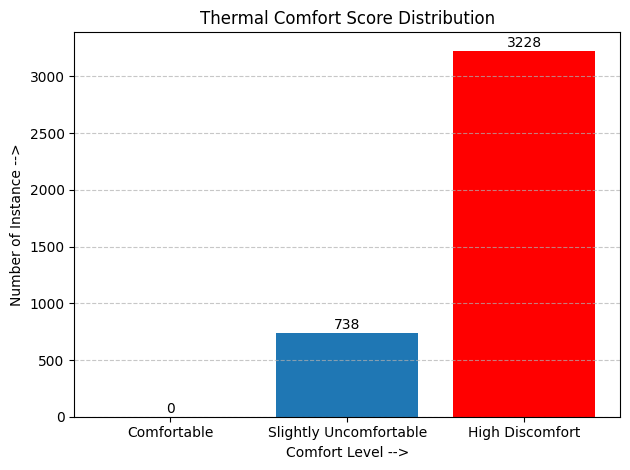

In [388]:
# Plotting the comfort score distribution
import matplotlib.pyplot as plt

# Count scores and ensure all categories are represented
score_labels = {0: "Comfortable", 1: "Slightly Uncomfortable", 2: "High Discomfort"}
score_counts = df['Comfort Score'].value_counts().sort_index()

# Fill missing score categories with 0
for score in score_labels:
    if score not in score_counts:
        score_counts[score] = 0

score_counts = score_counts.sort_index()

# Assign colors: red for 'High Discomfort' (score 2)
colors = ['#1f77b4', '#1f77b4', 'red']

# Plot
bars = plt.bar(score_counts.index, score_counts.values, 
               tick_label=[score_labels[s] for s in score_counts.index],
               color=colors)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 10, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

# Labels & styling
plt.xlabel("Comfort Level -->")
plt.ylabel("Number of Instance -->")
plt.title("Thermal Comfort Score Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The Ashare Comfort Zones are slightly modified to adjust to Singapore's temperature

/var/folders/zl/2t5vnbxd1pl_tjbrjjs5mzp80000gn/T/ipykernel_2016/233792296.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[score_labels[s] for s in score_counts.index], y=score_counts.values, palette=['#2ca02c', '#ff7f0e', '#d62728'])


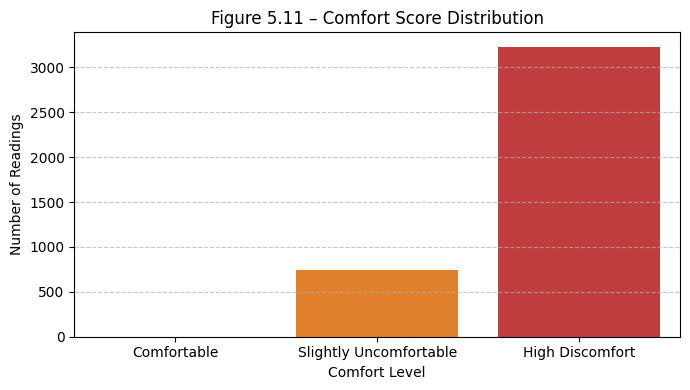

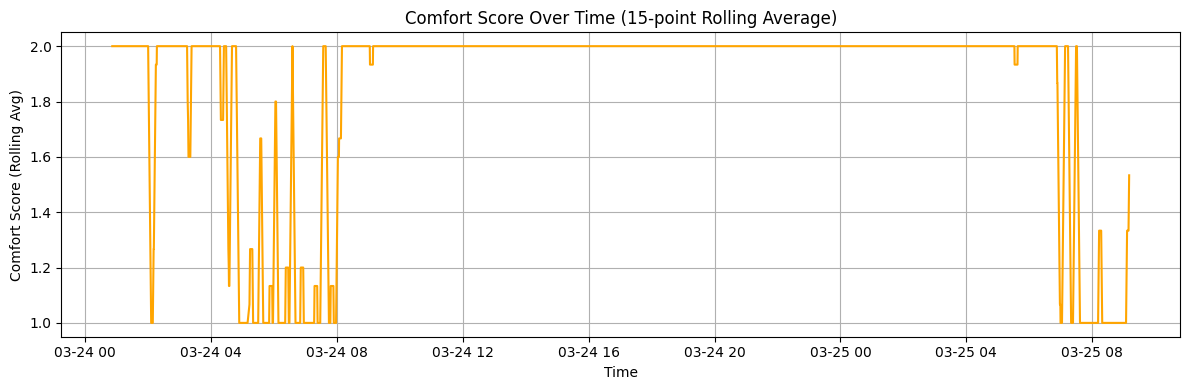

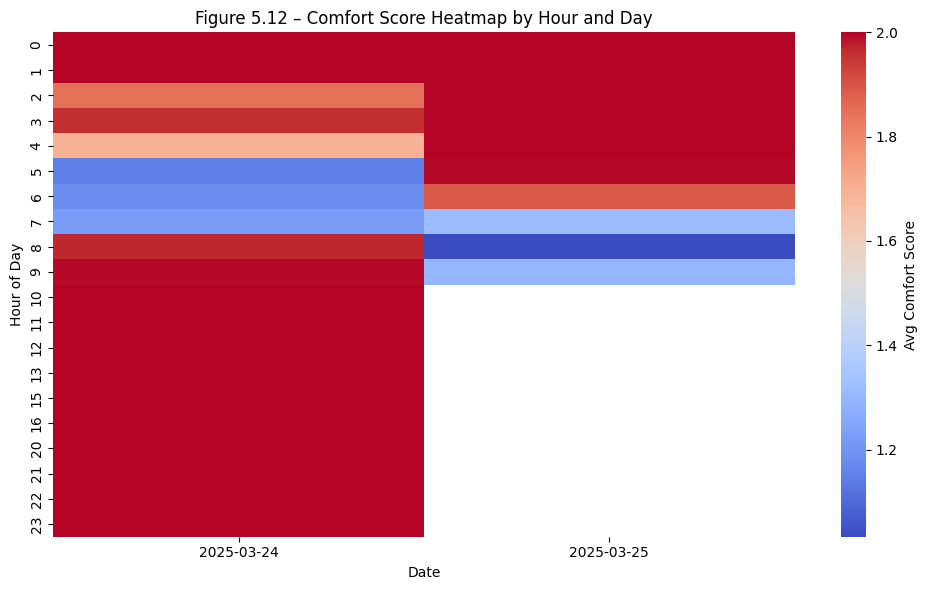

In [422]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Bar Chart of Comfort Score Distribution

score_labels = {0: 'Comfortable', 1: 'Slightly Uncomfortable', 2: 'High Discomfort'}
score_counts = df['Comfort Score'].value_counts().reindex([0, 1, 2], fill_value=0)

plt.figure(figsize=(7, 4))
sns.barplot(x=[score_labels[s] for s in score_counts.index], y=score_counts.values, palette=['#2ca02c', '#ff7f0e', '#d62728'])
plt.xlabel("Comfort Level")
plt.ylabel("Number of Readings")
plt.title("Figure 5.11 – Comfort Score Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Comfort Score Over Time

# Line Plot (Comfort Score rolling average over time)
df['Comfort_Rolling'] = df['Comfort Score'].rolling(window=15, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Comfort_Rolling'], color='orange')
plt.ylabel("Comfort Score (Rolling Avg)")
plt.xlabel("Time")
plt.title("Comfort Score Over Time (15-point Rolling Average)")
plt.grid(True)
plt.tight_layout()
plt.show()

# # Heatmap of hourly discomfort per day
# df['Date'] = df.index.date
# df['Hour'] = df.index.hour

# comfort_heatmap = df.pivot_table(index='Hour', columns='Date', values='Comfort Score', aggfunc='mean')

# plt.figure(figsize=(10, 6))
# sns.heatmap(comfort_heatmap, cmap='coolwarm', annot=False, cbar_kws={'label': 'Avg Comfort Score'})
# plt.title("Figure 5.12 – Comfort Score Heatmap by Hour and Day")
# plt.xlabel("Date")
# plt.ylabel("Hour of Day")
# plt.tight_layout()
# plt.show()


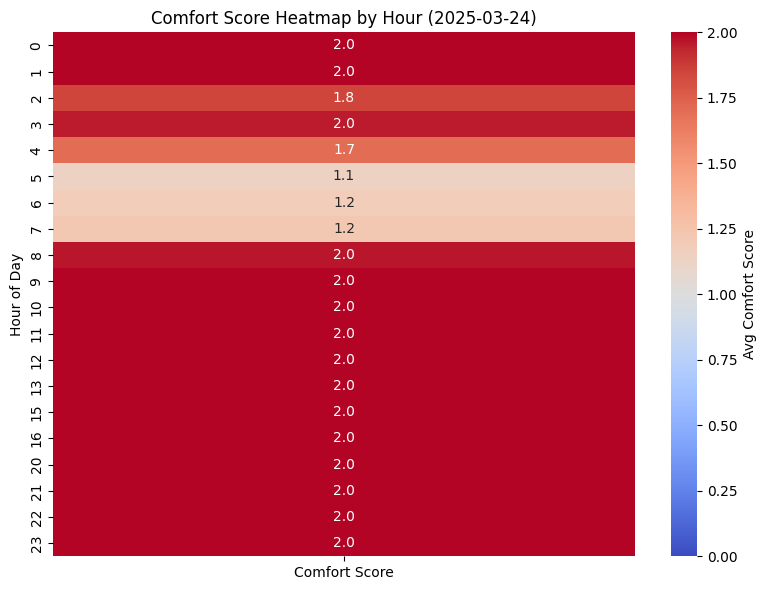

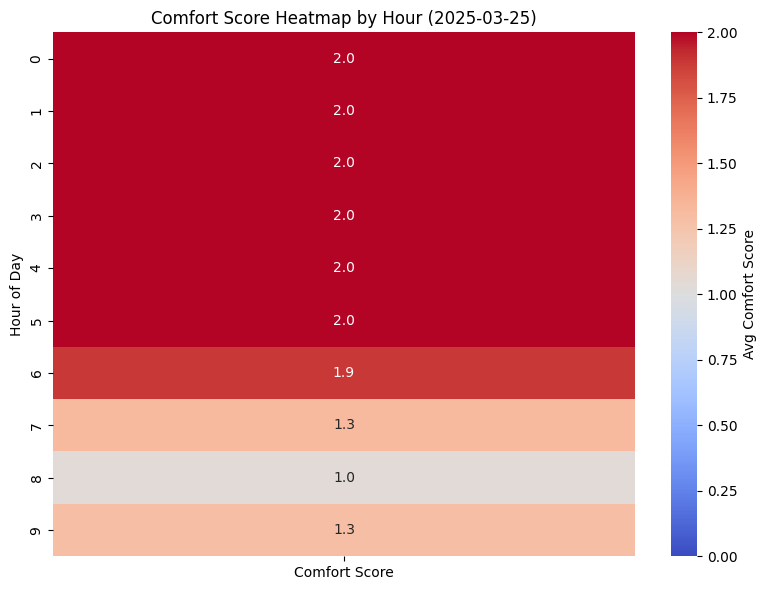

In [421]:
# Heatmap of hourly discomfort per day
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime and hour features exist
df['Date'] = df.index.date
df['Hour'] = df.index.hour

# Get unique dates
unique_days = df['Date'].unique()

# Loop over each day and create a separate heatmap
for day in unique_days:
    day_df = df[df['Date'] == day]
    
    # Pivot: Hour vs Comfort Score mean
    comfort_map = day_df.pivot_table(index='Hour', values='Comfort Score', aggfunc='mean')
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        comfort_map,
        cmap='coolwarm',
        annot=True,
        fmt='.1f',
        vmin=0,
        vmax=2,
        cbar_kws={'label': 'Avg Comfort Score'}
    )
    
    plt.title(f"Comfort Score Heatmap by Hour ({day})")
    plt.ylabel("Hour of Day")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


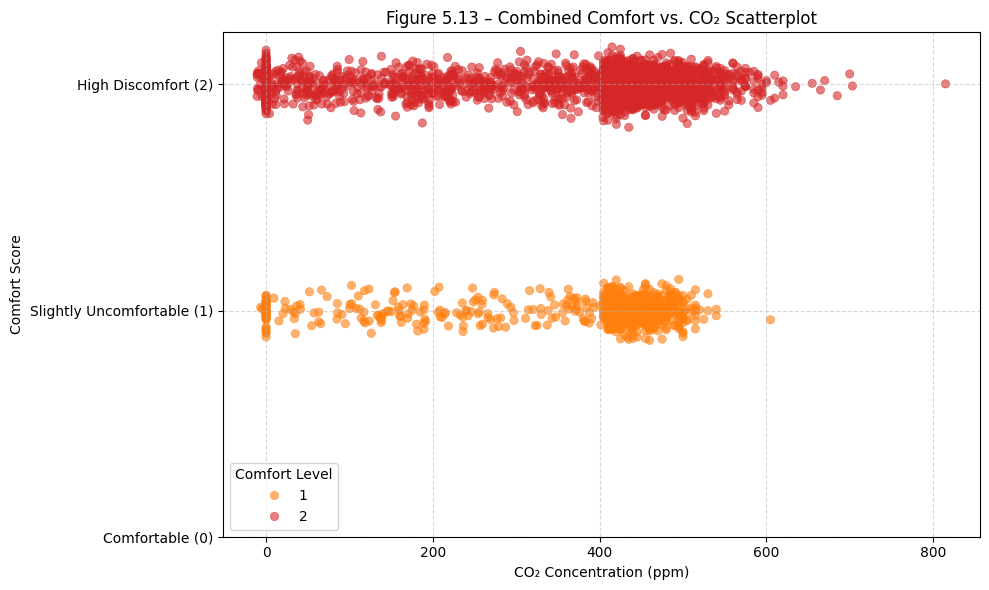

In [391]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add slight jitter to spread comfort scores
df['Comfort Score (Jittered)'] = df['Comfort Score'] + np.random.normal(0, 0.05, size=len(df))

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Co2',
    y='Comfort Score (Jittered)',
    hue='Comfort Score',
    palette={0: '#2ca02c', 1: '#ff7f0e', 2: '#d62728'},
    alpha=0.6,
    edgecolor=None
)

plt.xlabel("CO₂ Concentration (ppm)")
plt.ylabel("Comfort Score")
plt.title("Figure 5.13 – Combined Comfort vs. CO₂ Scatterplot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yticks([0, 1, 2], ['Comfortable (0)', 'Slightly Uncomfortable (1)', 'High Discomfort (2)'])
plt.tight_layout()
plt.legend(title="Comfort Level", loc='best')
plt.show()


Zone	Meaning
Low CO₂, High Score	Poor comfort, but low infection risk (e.g., high temp, RH imbalance)
High CO₂, Low Score	Good comfort, high transmission risk (under-ventilated)
High CO₂ & High Score	Worst case: uncomfortable and risky
Low CO₂ & Low Score	Ideal zone

As Singapore is a Tropical Country, the humidity and temperature levels are high, therefore, it is creating uncomfortable environment in lift. Especially, as it is also a naturally ventilated lift. 

#### Anomaly Detection in CO₂ Patterns Model

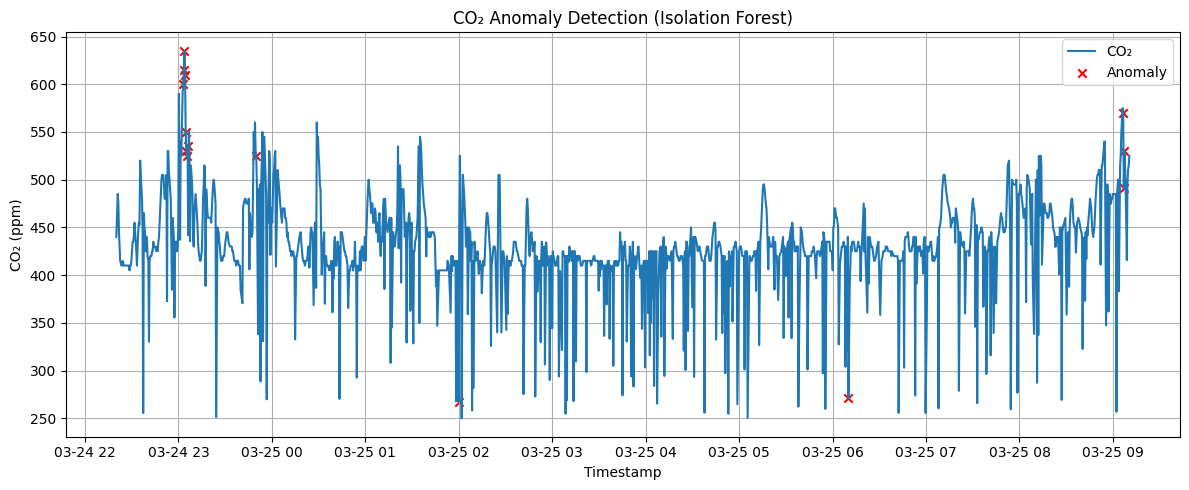

Total anomalies detected: 14


In [392]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt


# Feature engineering for CO₂ trends 
# Optionally smooth or compute rolling average for more stable features
data['Co2_Smooth'] = data['Co2'].rolling(window=5, min_periods=1).mean()

# You can also create lagged features or CO₂ deltas if needed
# df['Co2_Delta'] = df['Co2'].diff()

# Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.01, random_state=42)  # 1% expected anomalies
data['Anomaly'] = model.fit_predict(data[['Co2_Smooth']])

# Map Isolation Forest output: -1 = anomaly, 1 = normal
data['Anomaly'] = data['Anomaly'].map({1: 0, -1: 1})  # 1 = Anomaly, 0 = Normal

# Visualization 
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Co2'], label='CO₂')
plt.scatter(data[data['Anomaly'] == 1].index, data[data['Anomaly'] == 1]['Co2'],
            color='red', label='Anomaly', marker='x')
plt.title("CO₂ Anomaly Detection (Isolation Forest)")
plt.xlabel("Timestamp")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print("Total anomalies detected:", data['Anomaly'].sum())


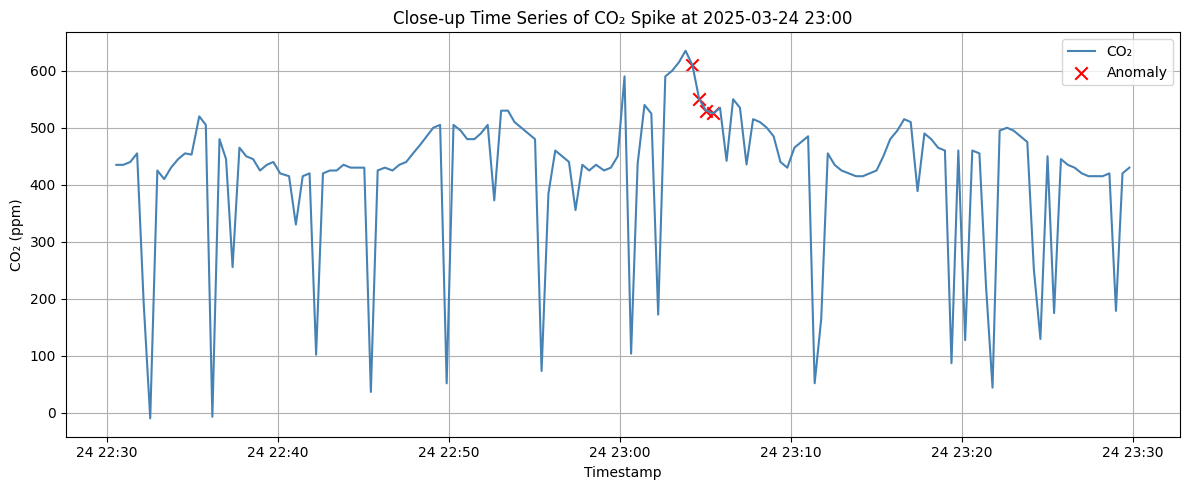

In [424]:
# Close up of CO₂ spike around 2025-03-24 23:00
import matplotlib.pyplot as plt

# --- Step 1: Define spike window around 2025-03-24 23:00 ---
start_time = pd.Timestamp("2025-03-24 22:30:00")
end_time = pd.Timestamp("2025-03-24 23:30:00")

zoom_df = df[(df.index >= start_time) & (df.index <= end_time)]

# --- Step 2: Plot CO₂ + anomalies in the time window ---
plt.figure(figsize=(12, 5))
plt.plot(zoom_df.index, zoom_df['Co2'], label='CO₂', color='steelblue')
plt.scatter(
    zoom_df.index[zoom_df['Anomaly'] == 1],
    zoom_df['Co2'][zoom_df['Anomaly'] == 1],
    color='red', marker='x', s=80, label='Anomaly'
)
plt.title("Close-up Time Series of CO₂ Spike at 2025-03-24 23:00")
plt.xlabel("Timestamp")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


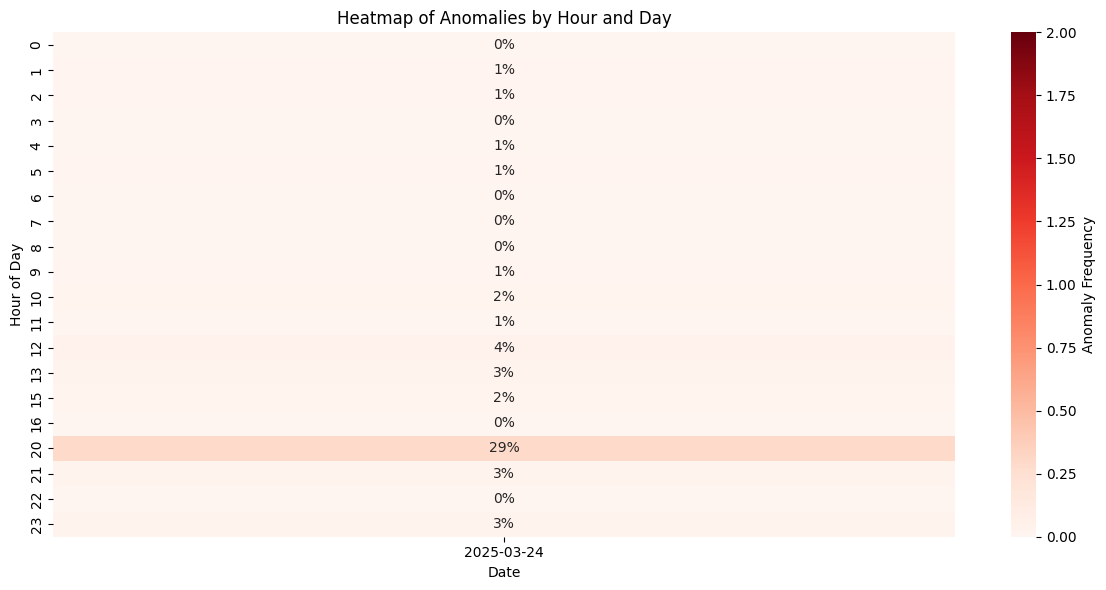

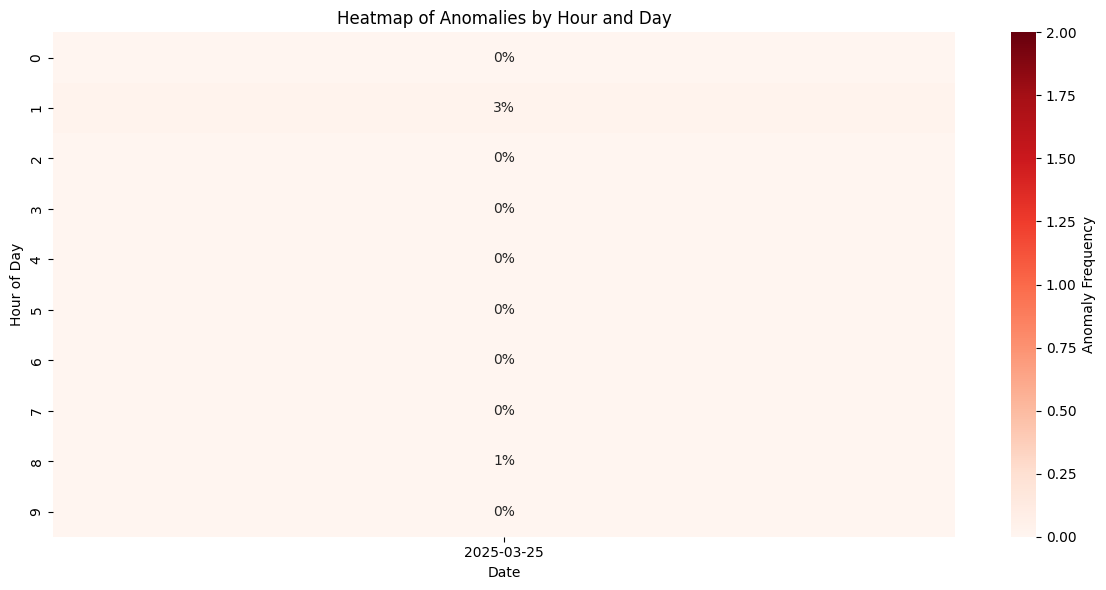

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 2: Feature engineering for CO₂ trends ---
# Optionally smooth or compute rolling average for more stable features
df['Co2_Smooth'] = df['Co2'].rolling(window=5, min_periods=1).mean()

# You can also create lagged features or CO₂ deltas if needed
# df['Co2_Delta'] = df['Co2'].diff()

# --- STEP 3: Isolation Forest ---
model = IsolationForest(contamination=0.01, random_state=42)  # 1% expected anomalies
df['Anomaly'] = model.fit_predict(df[['Co2_Smooth']])

# Map Isolation Forest output: -1 = anomaly, 1 = normal
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})  # 1 = Anomaly, 0 = Normal

# Only keep relevant entries
if 'Anomaly' not in df.columns:
    raise ValueError("You must run anomaly detection first (e.g. Isolation Forest) and add 'Anomaly' column.")

df['Date'] = df.index.date
df['Hour'] = df.index.hour
unique_days = df['Date'].unique()



for day in unique_days:
    day_df = df[df['Date'] == day]
    
    # --- Step 2: Pivot Table for Heatmap (Mean = % of anomaly presence) ---
    heatmap_data = day_df.pivot_table(index='Hour', columns='Date', values='Anomaly', aggfunc='mean')

    # --- Step 3: Plot ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data,
        cmap='Reds',
        # linewidths=0.3,          # ✅
        linecolor='gray',
        annot=True,
        fmt='.0%',
        vmin=0,
        vmax=2,
        cbar_kws={'label': 'Anomaly Frequency'}
    )
    plt.title("Heatmap of Anomalies by Hour and Day")
    plt.xlabel("Date")
    plt.ylabel("Hour of Day")
    plt.tight_layout()
    plt.show()
    




Spikes at 03-24 23:00 and again near 03-25 09:00: \
These are likely overcrowding events, stuck lift scenarios, or moments of very poor ventilation, leading to rapid CO₂ accumulation. 

Sudden drops or flat-lining (03-25 06:00): \
May indicate sensor dropout, door stuck open, or sudden air flushing event. 

####  Time Series Clustering (Usage Profiling)

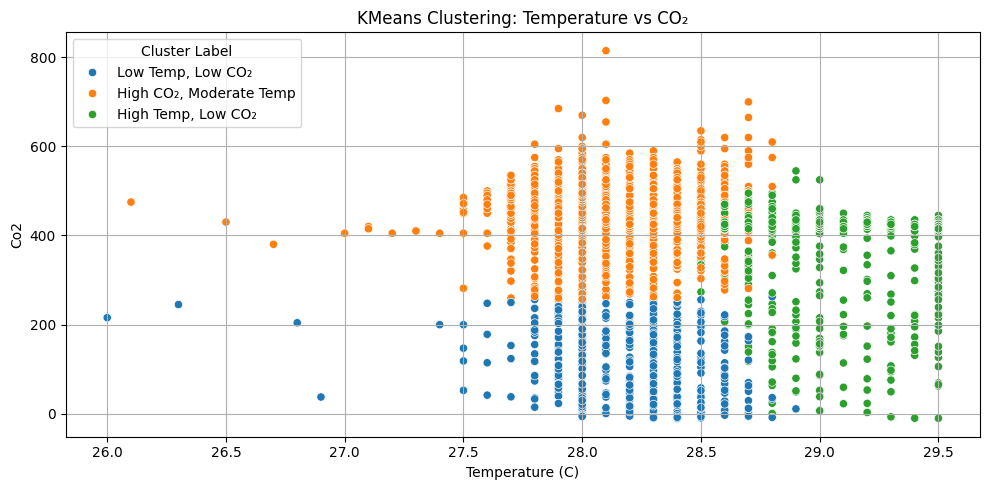

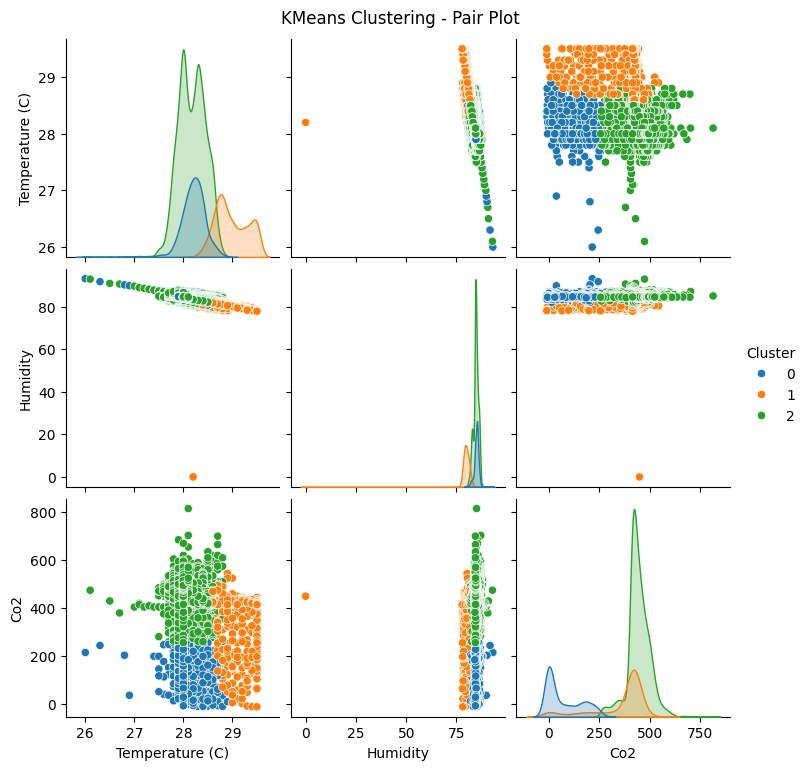

🔍 Cluster Centroids:
 0        Temperature (C)   Humidity         Co2
Cluster                                        
0              28.203547  84.845157   73.518872
1              28.976073  79.835891  355.142283
2              28.169156  84.572930  443.460906


In [393]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Load and clean your data
# Ensure 'Timestamp' is datetime
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# STEP 2: Select features for clustering
features = df[['Temperature (C)', 'Humidity', 'Co2']].copy()

# Drop rows with missing values
features = features.dropna()

# STEP 3: Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# STEP 4: Apply KMeans Clustering
k = 3  # you can change this based on elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# STEP 4.5: Map cluster numbers to descriptive labels
label_map = {
    0: "Low Temp, Low CO₂",
    1: "High Temp, Low CO₂",
    2: "High CO₂, Moderate Temp"
}

df['Cluster Label'] = df['Cluster'].map(label_map)

# STEP 5: Visualize Cluster Assignments
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Temperature (C)', y='Co2', hue='Cluster Label', palette='tab10')
plt.title('KMeans Clustering: Temperature vs CO₂')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot with humidity too
sns.pairplot(df, vars=['Temperature (C)', 'Humidity', 'Co2'], hue='Cluster', palette='tab10')
plt.suptitle("KMeans Clustering - Pair Plot", y=1.02)
plt.show()

# STEP 6: Cluster statistics (optional)
cluster_summary = df.groupby('Cluster')[['Temperature (C)', 'Humidity', 'Co2']].mean()
print("🔍 Cluster Centroids:\n", cluster_summary)

Cluster 0 (Low Temp, Low CO₂): These are likely periods of low or no occupancy, with good ventilation keeping CO₂ levels low.

Cluster 1 (High CO₂, Moderate Temp): This profile suggests poor ventilation or overcrowding — elevated CO₂ levels in a moderate thermal environment. These hours may correlate with peak usage or stuck lift scenarios.

Cluster 2 (High Temp, Low CO₂): While temperatures are high, the low CO₂ indicates good ventilation or short durations, potentially when the lift was hot but not occupied long enough to build CO₂.

#### Forecasting CO₂ Levels (Short-Term Risk) - Predict future CO₂ peaks

🔍 MAE (10 min CO₂ forecast): 37.27 ppm
📐 RMSE (Root Mean Squared Error): 52.49 ppm
📊 R² Score (Regression Accuracy): 0.0459


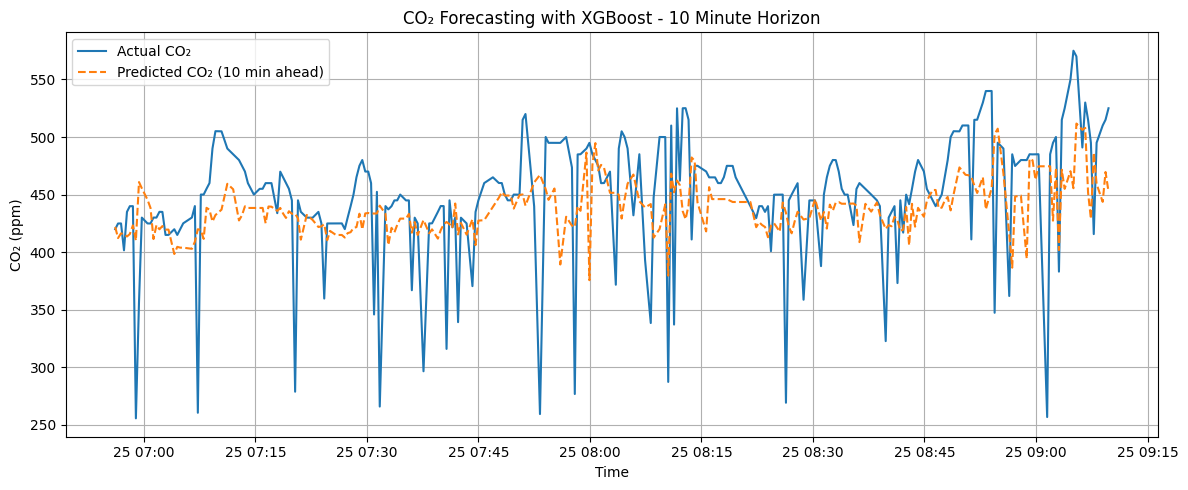

In [394]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# --- STEP 1: Prepare data ---
df1 = data[['Co2', 'Temperature (C)', 'Humidity']].copy()

# --- STEP 2: Create time-based features ---
df1['hour'] = df1.index.hour
df1['minute'] = df1.index.minute

# --- STEP 3: Create lag features ---
for lag in (1, 2):  # adjust based on your time resolution
    df1[f'Co2_lag_{lag}'] = df1['Co2'].shift(lag)

# --- STEP 4: Create target (forecast 10 mins ahead) ---
forecast_horizon = 2 * 60  # 10 minutes in seconds
interval = (df1.index[1] - df1.index[0]).seconds
lag_steps = int(forecast_horizon / interval)

df1['Co2_future'] = df1['Co2'].shift(-lag_steps)

# --- STEP 5: Clean ---
df1 = df1.dropna()

# --- STEP 6: Train-test split ---
X = df1.drop('Co2_future', axis=1)
y = df1['Co2_future']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# --- STEP 7: Train XGBoost model ---
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

# --- STEP 8: Predict + Evaluate ---
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"🔍 MAE (10 min CO₂ forecast): {mae:.2f} ppm")
print(f"📐 RMSE (Root Mean Squared Error): {rmse:.2f} ppm")
print(f"📊 R² Score (Regression Accuracy): {r2:.4f}")

# --- STEP 9: Plot actual vs predicted ---
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual CO₂')
plt.plot(y_test.index, y_pred, label='Predicted CO₂ (10 min ahead)', linestyle='--')
plt.title("CO₂ Forecasting with XGBoost - 10 Minute Horizon")
plt.xlabel("Time")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Risk Classification


📊 Classification Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00         5
       Alert       1.00      1.00      1.00       228
      Unsafe       1.00      1.00      1.00       561

    accuracy                           1.00       794
   macro avg       1.00      1.00      1.00       794
weighted avg       1.00      1.00      1.00       794


📉 Confusion Matrix:
[[  5   0   0]
 [  0 228   0]
 [  0   0 561]]


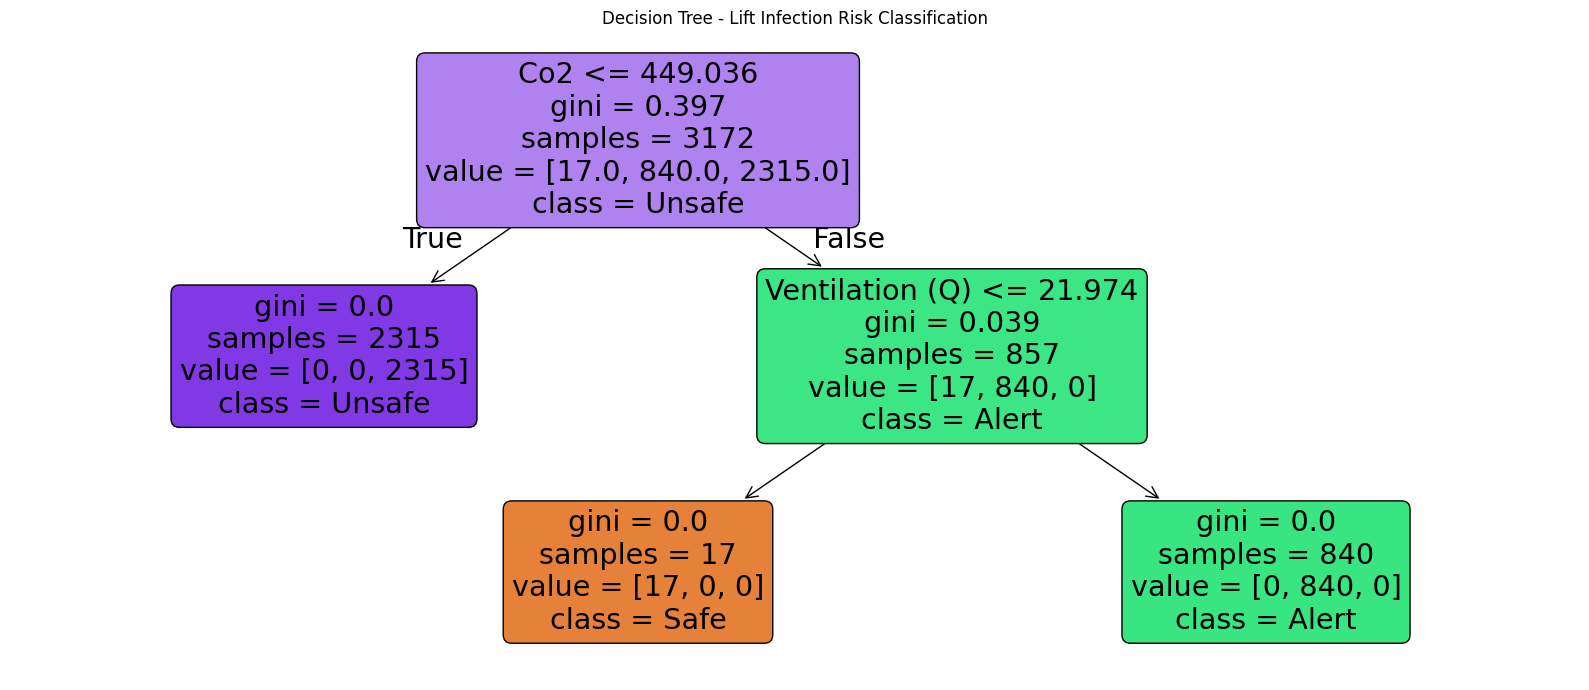

In [395]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree

# --- STEP 1: Prepare DataFrame (clean + select features) ---
vars_to_use = [
    'Co2', 'Temperature (C)', 'Humidity', 'Comfort Score', 'Ventilation (Q)',
    'COVID-19 Risk', 'Measles Risk', 'Tuberculosis Risk'
]

df_model = df[vars_to_use].copy()
df_model = df_model.dropna()

# --- STEP 2: Define Risk Category Based on CO₂ ---
# def risk_label(co2):
#     if co2 > 700:
#         return 'Unsafe'
#     elif co2 > 500:
#         return 'Alert'
#     else:
#         return 'Safe'

def risk_label(ventilation):
    if ventilation > 29:
        return 'Unsafe'
    elif ventilation > 22:
        return 'Alert'
    else:
        return 'Safe'

# df_model['Risk Label'] = df_model['Co2'].apply(risk_label)
df_model['Risk Label'] = df_model['Ventilation (Q)'].apply(risk_label)

# Encode label to numeric
label_map = {'Safe': 0, 'Alert': 1, 'Unsafe': 2}
df_model['Risk Code'] = df_model['Risk Label'].map(label_map)

# --- STEP 3: Split Data ---
X = df_model[vars_to_use]
y = df_model['Risk Code']

# Safe split even with few classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- STEP 4: Train Classifier ---
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# --- STEP 5: Evaluate Model ---
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Alert', 'Unsafe']))
print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- STEP 6: Visualize Tree ---
plt.figure(figsize=(16, 7))
tree.plot_tree(clf,
               feature_names=vars_to_use,
               class_names=['Safe', 'Alert', 'Unsafe'],
               filled=True,
               rounded=True)
plt.title("Decision Tree - Lift Infection Risk Classification")
plt.tight_layout()
plt.show()



📊 Classification Report:
               precision    recall  f1-score   support

         Safe       1.00      1.00      1.00       447
Moderate Risk       1.00      1.00      1.00       346
    High Risk       1.00      1.00      1.00         1

     accuracy                           1.00       794
    macro avg       1.00      1.00      1.00       794
 weighted avg       1.00      1.00      1.00       794


📉 Confusion Matrix:
[[447   0   0]
 [  0 346   0]
 [  0   0   1]]


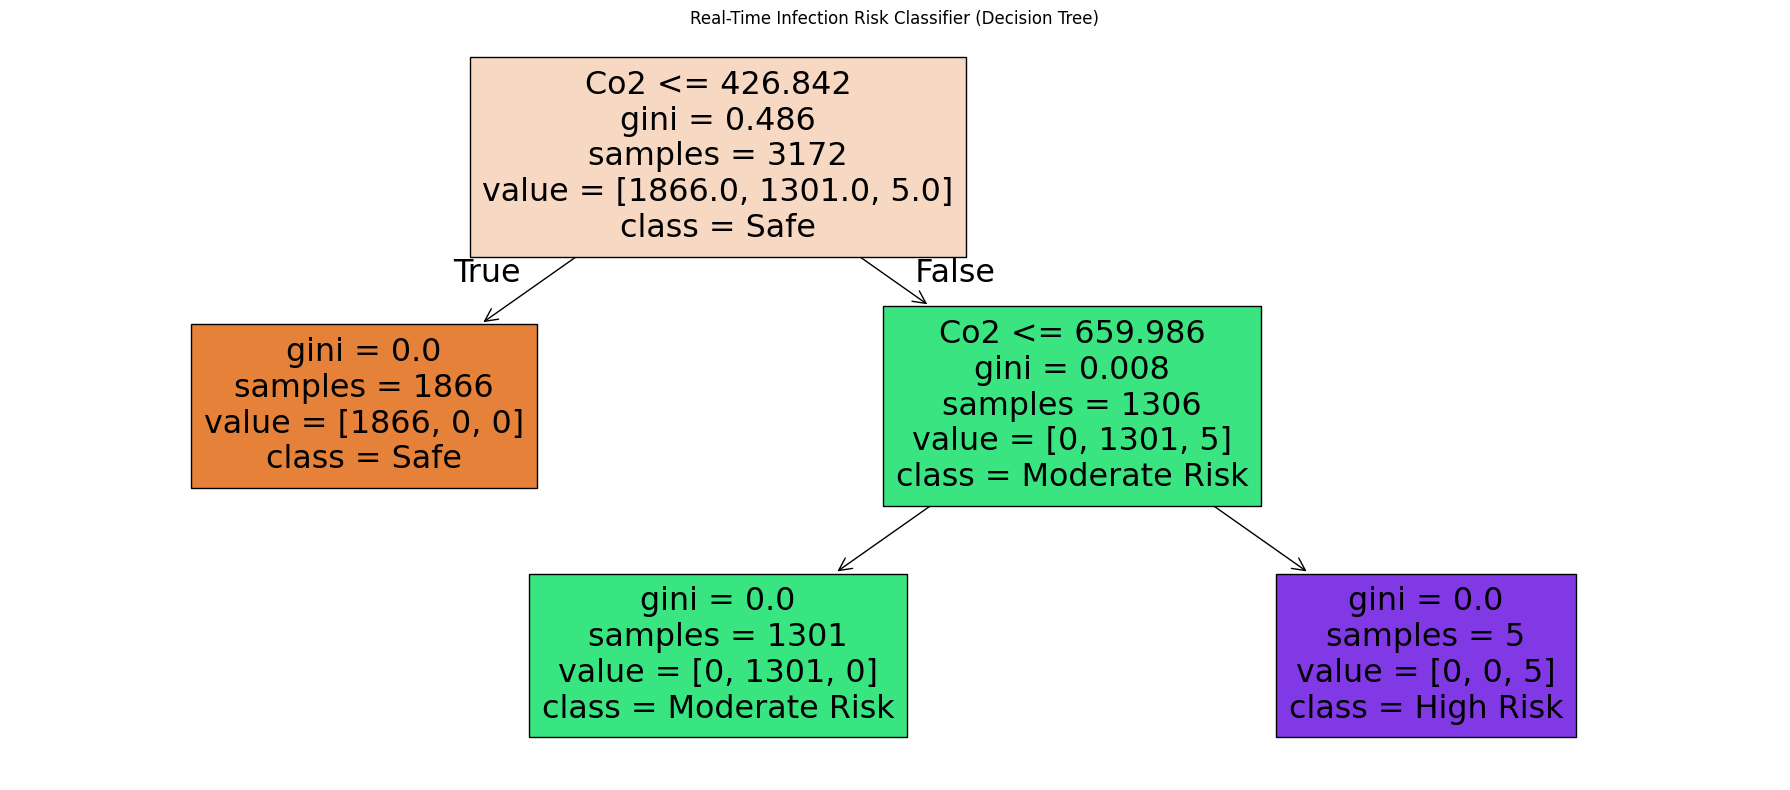

In [396]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

df_model = df[['Co2', 'Temperature (C)', 'Humidity', 'Comfort Score', 'COVID-19 Risk', 'Comfort Score']].copy()
df_model = df_model.dropna()


# --- STEP 3: Define Target Risk Level Based on COVID-19 Wells-Riley Risk ---
def covid_risk_label(risk):
    if risk < 0.013:
        return 'Safe'
    elif risk < 0.02:
        return 'Moderate Risk'
    else:
        return 'High Risk'

df_model['Risk Label'] = df_model['COVID-19 Risk'].apply(covid_risk_label)
label_map = {'Safe': 0, 'Moderate Risk': 1, 'High Risk': 2}
df_model['Risk Code'] = df_model['Risk Label'].map(label_map)

# --- STEP 4: Features and Labels ---
features = [
    'Co2', 'Temperature (C)', 'Humidity', 'Comfort Score'
]

X = df_model[features]
y = df_model['Risk Code']

# --- STEP 5: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- STEP 6: Train Classifier ---
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# --- STEP 7: Evaluate ---
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Moderate Risk', 'High Risk']))
print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- STEP 8: Visualize the Tree ---
plt.figure(figsize=(18, 8))
tree.plot_tree(clf, feature_names=features, class_names=['Safe', 'Moderate Risk', 'High Risk'], filled=True)
plt.title("Real-Time Infection Risk Classifier (Decision Tree)")
plt.tight_layout()
plt.show()


In [397]:
df['COVID-19 Risk'].describe()

count    3966.000000
mean        0.013267
std         0.001248
min         0.012246
25%         0.012246
50%         0.012824
75%         0.013881
max         0.024732
Name: COVID-19 Risk, dtype: float64